In [2]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from scipy import stats


## Styling

In [3]:
# plt.style.use('seaborn')
# plt.style.use("classic")

In [4]:
%%script false --no-raise-error


# check which fonts are available
# import matplotlib.font_manager
# font = matplotlib.font_manager.FontProperties(family='sans serif')
# file = matplotlib.font_manager.findfont(font)
# print(file)
# plot settings?
plt.rc('font',family='sans-serif')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["mathtext.fontset"] = 'dejavuserif'
plt.rcParams["figure.figsize"] = (3.25, 2.1)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linestyle'] = '--'
plt.rcParams['lines.markersize'] = 3
plt.rcParams['font.size'] = 7
plt.rcParams['figure.titlesize'] = 7
plt.rcParams["legend.labelspacing"] = 0.3
plt.rcParams["legend.handletextpad"] = 0.3
plt.rcParams["legend.handlelength"] = 1.0
# plt.rcParams["font.sans-serif"] = 'Arial'
# plt.rcParams["font.sans-serif"] = 'DejaVuSans'
plt.rcParams["axes.labelpad"] = 1.5
plt.rcParams["lines.markeredgewidth"] = 0.01
plt.rcParams["xtick.major.size"] = 3.0
plt.rcParams["ytick.major.size"] = 3.0
#plt.rcParams["xtick.major.width"] = 1.5
#plt.rcParams["ytick.major.width"] = 1.5


Couldn't find program: 'false'


## Reading in data

In [6]:
def reading_data():
    df1 = pd.read_excel("./adapted_sheets/1_MACE_descriptors.xlsx")
    df2 = pd.read_excel("./adapted_sheets/2_gfnff_descriptors.xlsx")
    df3 = pd.read_excel("./adapted_sheets/3_gfn2_descriptors.xlsx")
    df4 = pd.read_excel("./adapted_sheets/4_DFT_descriptors.xlsx")
    return df1,df2,df3,df4

df1,df2,df3,df4 = reading_data()    
cols = df4.columns
units = ["", "(°)", "(°)", "", "(kcal¹ᐟ² mol⁻¹⸍²)", "", "(eV)", "(a.u.)", "(eV)", "(eV)", "(eV)", "(eV)", "(eV)", "(a.u.)" ]

#cols = ['Unnamed: 0', 'bite_angle', 'cone_angle', 'buried_volume', 'dispersion',
#       'sasa', 'ip', 'dipole', 'ea', 'electrofugality', 'nucleofugality',
#       'nucleophilicity', 'electrophilicity', 'HOMO_LUMO_gap']

<AxesSubplot:>

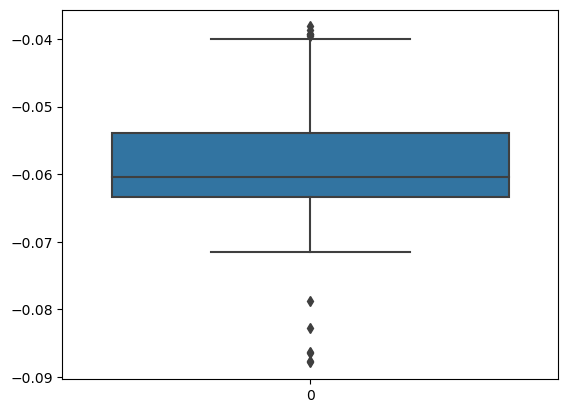

In [6]:
sns.boxplot(data=df4["HOMO_LUMO_gap"])

## Filtering 

In [8]:
def filter(df_first: pd.DataFrame, df_second: pd.DataFrame, col_nr: int):
    
    Q1 = np.percentile(df_first[cols[col_nr]],25, interpolation = 'midpoint')
    Q3 = np.percentile(df_first[cols[col_nr]],75, interpolation = 'midpoint')
    IQR = Q3 - Q1
    
    print(cols[col_nr], ":\n")
    print("Old shape: ", df_first.shape, df_second.shape)

    upper = np.where(df_first[cols[col_nr]] >= (Q3 + 1.5*IQR))
    lower = np.where(df_first[cols[col_nr]] <= (Q1 - 1.5*IQR))

    df1_filtered = df_first.drop(upper[0])
    df1_filtered = df1_filtered.drop(lower[0])
    df2_filtered = df_second.drop(upper[0])
    df2_filtered = df2_filtered.drop(lower[0])

    print("new shape: ", df1_filtered.shape, df2_filtered.shape)

    
    print("-"*50)

    if len(upper[0] >= 0):
        for i in upper[0]:
            print("Filtered out (upper bound):", df1.iloc[i,0], "on pos", i)

    if len(lower[0] >= 0):
        for i in lower[0]:
            print("Filtered out: (lower bound):", df2.iloc[i,0], "on pos", i)

    return df1_filtered, df2_filtered, upper, lower


def filter_series(s1: pd.Series, s2: pd.Series):
    Q1 = np.percentile(s1,25, interpolation = 'midpoint')
    Q3 = np.percentile(s1,75, interpolation = 'midpoint')
    IQR = Q3 - Q1

    print("Old shape: ", s1.size, s2.size)

    upper = np.where(s1 >= (Q3 + 1.5*IQR))
    lower = np.where(s1 <= (Q1 - 1.5*IQR))

    s1_filter = s1.drop(upper[0])
    s1_filter = s1_filter.drop(lower[0])
    s2_filter = s2.drop(upper[0])
    s2_filter = s2_filter.drop(lower[0])

    print("new shape: ", s1_filter.size, s2_filter.size)

    if len(upper[0] >= 0):
        for i in upper[0]:
            print("Filtered out (upper bound):", s1[i], "on pos", i)

    if len(lower[0] >= 0):
        for i in lower[0]:
            print("Filtered out: (lower bound):", s2.iloc[i], "on pos", i)
            
    return s1_filter, s2_filter, upper, lower




### Saving outliers

In [9]:

def save_outliers(df1, df2, col_nr, name: str = "outlier_structures.txt"):
    """ 
    Saves the failed ligands to outlier file 
    """
    df1_filter, df2_filter, upper, lower = filter(df1,df2,col_nr)

    with open (name, 'w') as f:
        for i in upper[0]:
            f.write(df1.iloc[i,0] + '\n')
        for i in lower[0]:
            f.write(df1.iloc[i,0] + "\n")
    
# save_outliers(df3,df4, -1)

## Plot and linear regress

In [10]:
class Plotter:
    def __init__(self, n = None):
        if n is not None:
            self.n = n
        else:
            self.n = 1    

    def plot_correlation(self, x: int, y: int, method: str):
        """ 
        Basically just plots your data
        """
        fig = plt.figure()
        fig.set_facecolor("white")
        
        plt.scatter(x,y)
        z = np.polyfit(x,y,1)
        p = np.poly1d(z)
        plt.plot(x, p(x), color="black")   
        plt.xlabel(method)    
        plt.ylabel("DFT")
        plt.title(cols[self.n])
        
        trend_line_str=f"{z[0]:.3f}x + {z[1]:.3f}" 
        print(trend_line_str)
        
        coefficient_of_determination = r2_score(y, p(x))
        MSE = mean_squared_error(y, x)
        RMSE = np.sqrt(MSE)
        

        print()

        x_cords = x.min() # x-coordinate for text in plot, left
        y_cords = y.min() + (0.9 * (y.max() - y.min()))  # y-coordinate for text in plot, 90% of top corner
        

        plt.annotate(f"R\u00B2 ={coefficient_of_determination:.2f} \nRMSE = {RMSE:.3f}", 
            (x_cords, y_cords),
            horizontalalignment="left",
            verticalalignment="bottom",
            fontsize=12) # to put r^2 in plot, like in excel

        # plt.text(x_cords, y_cords, s=trend_line_str) # to put line in plot, like in excel

        # r2_filters.append(coefficient_of_determination)
        # RMSE_filters.append(np.sqrt(MSE))
    
    def increment(self):
        self.n+=1
        return self.n


#### Create csv file with r^2 values

In [10]:
%%script false --no-raise-error

import csv

r2_ogs, RMSE_ogs = [], []
r2_filters, RMSE_filters = [], []

header= ["", "r2_org", "r2_filter", "RMSE_org", "RMSE_filter"]
lst=[]

for i in range(len(r2_ogs)):
    lst.append([cols[i+1],r2_ogs[i], r2_filters[i], RMSE_ogs[i], RMSE_filters[i]])


with open("filter_r2_comparison.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(lst)

# print(r2_ogs, RMSE_ogs)
# print(r2_filters, RMSE_filters)


Couldn't find program: 'false'


### Linear regression plots

#### MACE vs DFT

Plot unfiltered

In [11]:
# plotter = Plotter()
# for i in range(1, len(cols)):
#     plotter.plot_correlation(df3.iloc[:, i], df4.iloc[:,i], "gfn2")
#     plotter.increment()
#     plt.savefig("./figs/gfn2_unfiltered_" + cols[i] + ".png")

Plots filtered

bite_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (59, 14) (59, 14)
--------------------------------------------------
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH2.xyz on pos 2
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH3.xyz on pos 3
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH4.xyz on pos 4
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH5.xyz on pos 5
Filtered out: (lower bound): [Ir+3]_136705-64-1_OH0.xyz on pos 12
Filtered out: (lower bound): [Ir+3]_136705-64-1_OH1.xyz on pos 13
Filtered out: (lower bound): [Ir+3]_136705-65-2_OH0.xyz on pos 14
Filtered out: (lower bound): [Ir+3]_136705-65-2_OH1.xyz on pos 15
Filtered out: (lower bound): [Ir+3]_147253-67-6_OH0.xyz on pos 25
Filtered out: (lower bound): [Ir+3]_147253-67-6_OH1.xyz on pos 26
496.285x + -44573.602

cone_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (69, 14) (69, 14)
--------------------------------------------------
0.035x + 327.838

buried_volume :

Old shape:  (69, 14) (69, 14)
ne

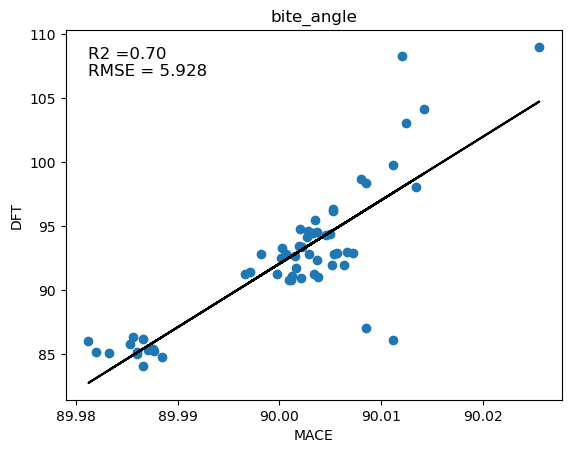

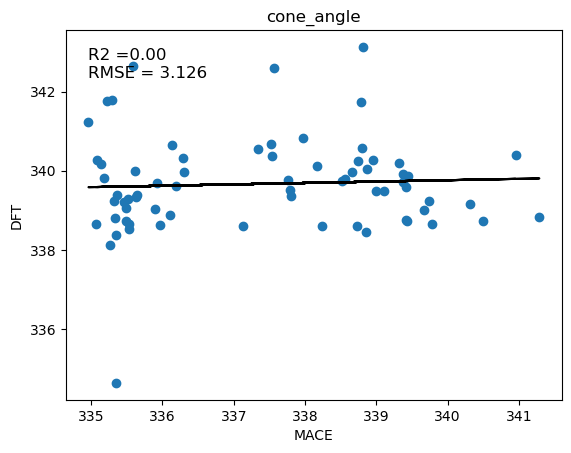

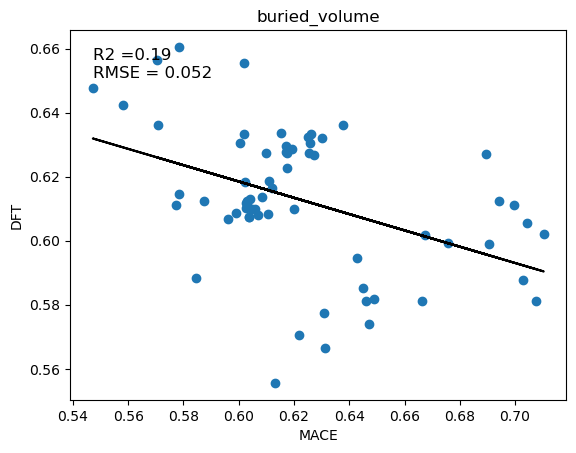

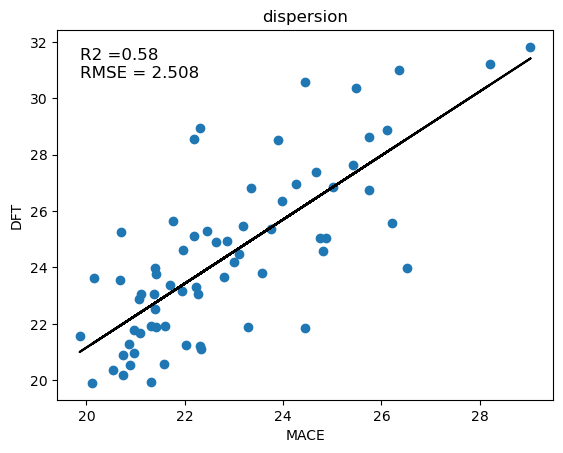

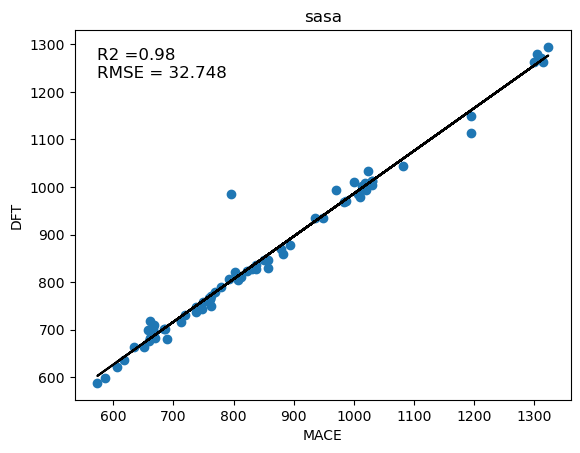

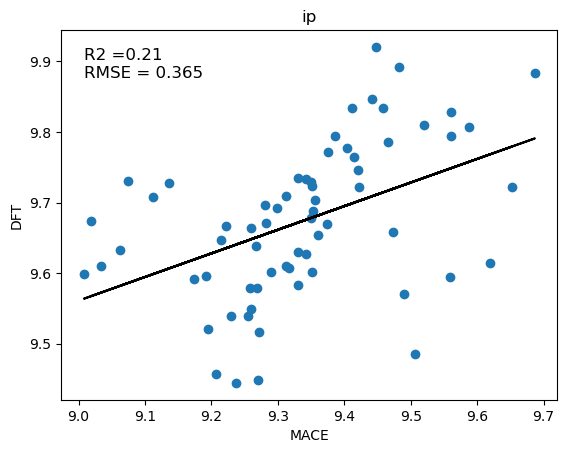

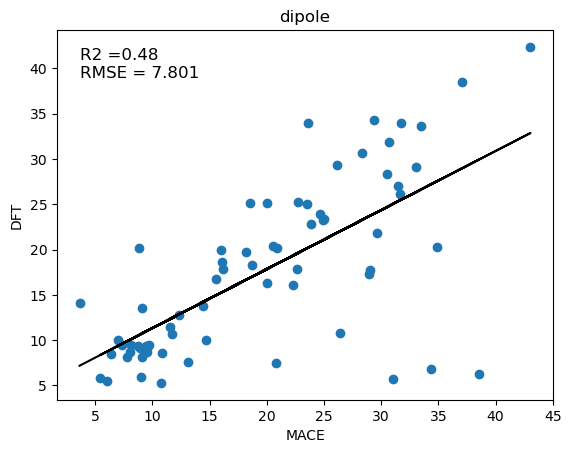

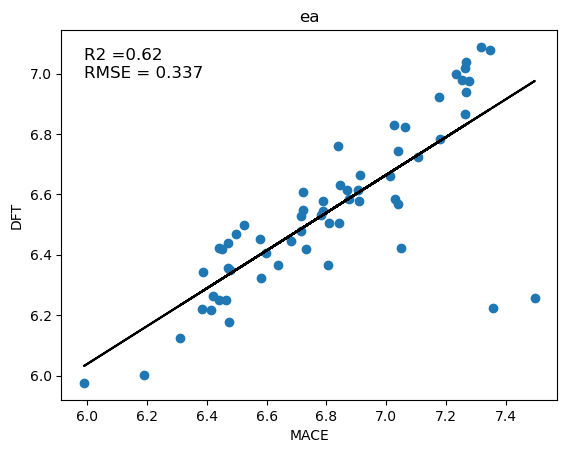

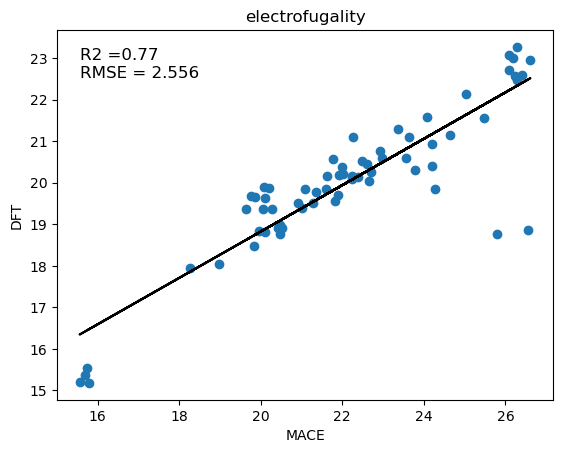

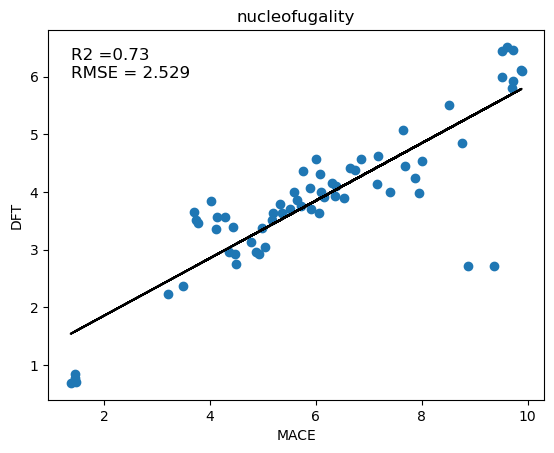

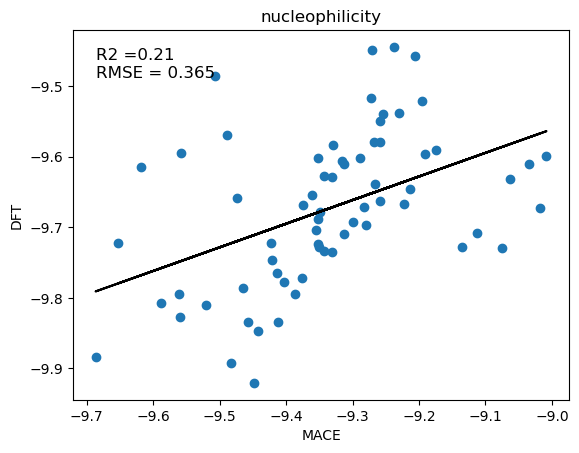

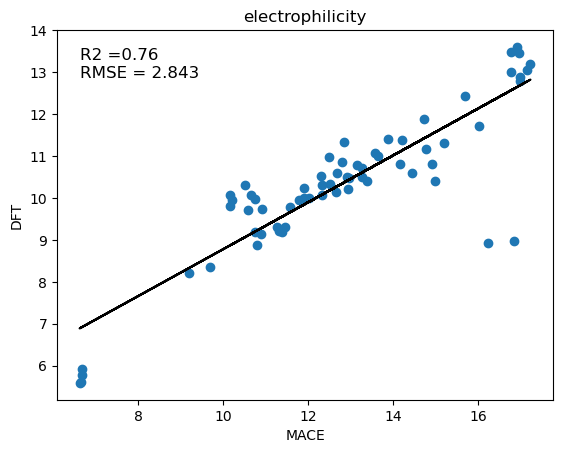

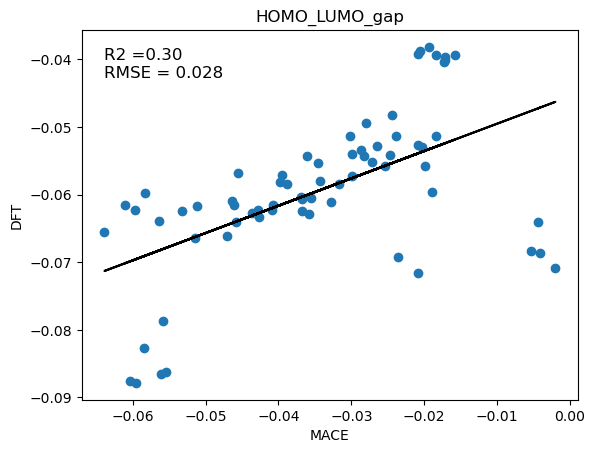

In [12]:
plotter = Plotter()

for i in range(1, len(cols)):
    df1_filtered, df4_filtered, upper, lower = filter(df1,df4,i)
    plotter.plot_correlation(df1_filtered.iloc[:, i], df4_filtered.iloc[:,i], "MACE")
    plotter.increment()
    #plt.savefig("./figs/MACE_filter_on_col_" + cols[i] + ".png")

#### gfn_ff vs DFT

Plot unfiltered

In [13]:
# plotter = Plotter()

# for i in range(1, len(cols)):
#     plotter.plot_correlation(df2.iloc[:, i], df2.iloc[:,i], "gfnff")
#     plotter.increment()
#     # plt.savefig("./figs/gfnff_filter_on_col_" + cols[i] + ".png")

Plots filtered

bite_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (65, 14) (65, 14)
--------------------------------------------------
Filtered out (upper bound): [Ir+3]_1202033-19-9_OH0.xyz on pos 0
Filtered out (upper bound): [Ir+3]_1202033-19-9_OH1.xyz on pos 1
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH0.xyz on pos 20
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH3.xyz on pos 22
1.000x + 0.000

cone_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (68, 14) (68, 14)
--------------------------------------------------
Filtered out: (lower bound): [Ir+3]_1429939-35-4_OH2.xyz on pos 21
1.000x + 0.000

buried_volume :

Old shape:  (69, 14) (69, 14)
new shape:  (55, 14) (55, 14)
--------------------------------------------------
Filtered out (upper bound): [Ir+3]_1202033-19-9_OH0.xyz on pos 0
Filtered out (upper bound): [Ir+3]_1202033-19-9_OH1.xyz on pos 1
Filtered out (upper bound): [Ir+3]_1202033-19-9_OH2.xyz on pos 2
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH3.xyz on pos 22


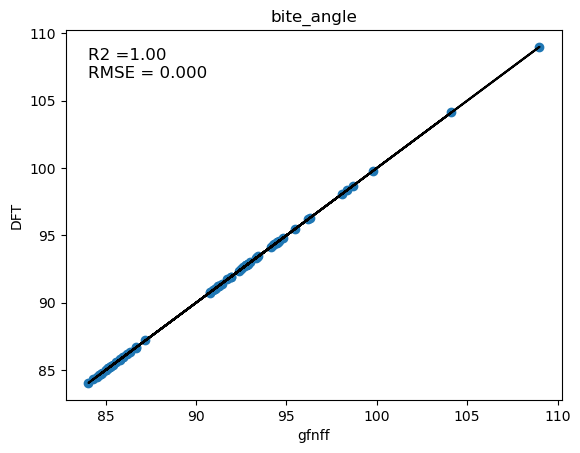

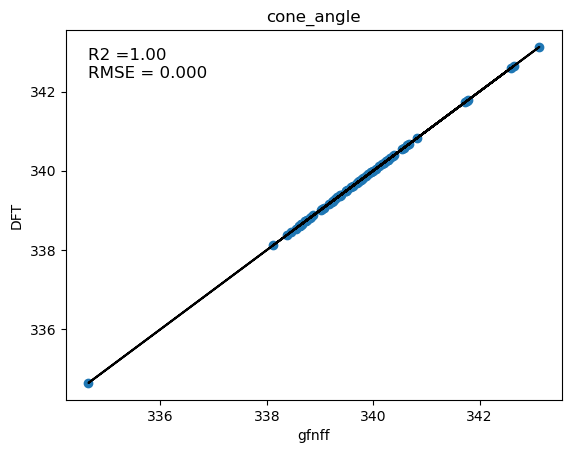

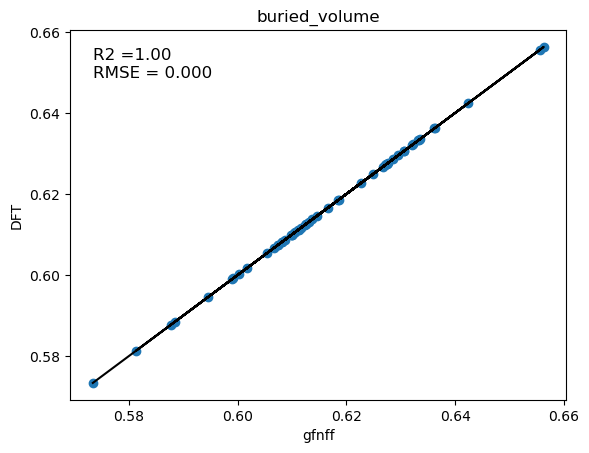

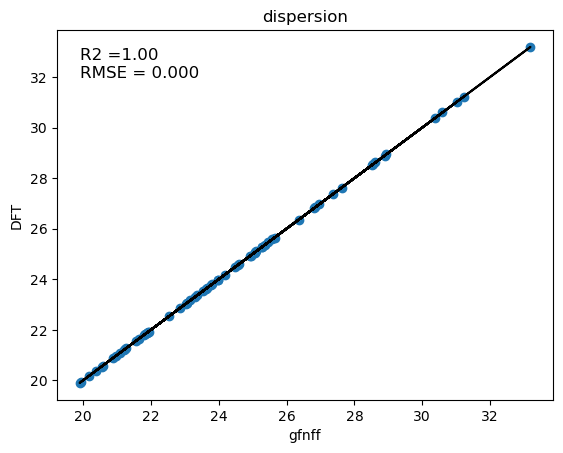

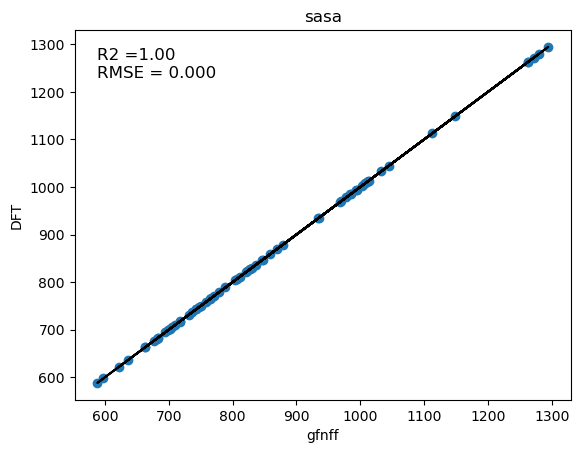

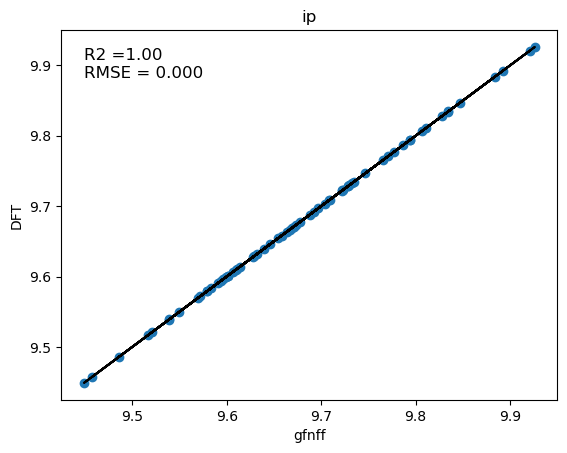

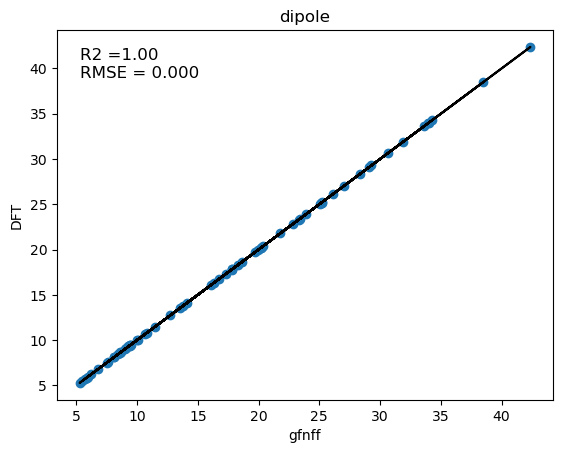

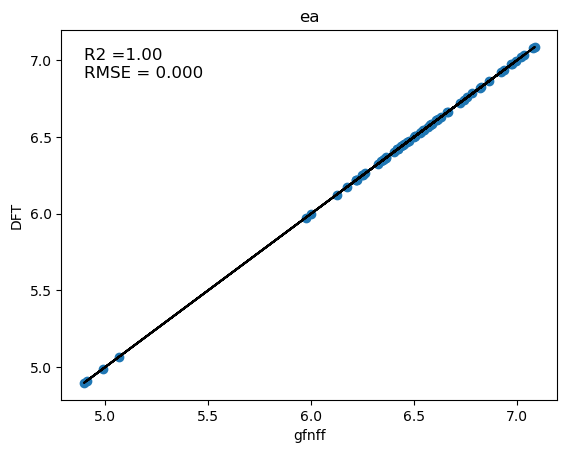

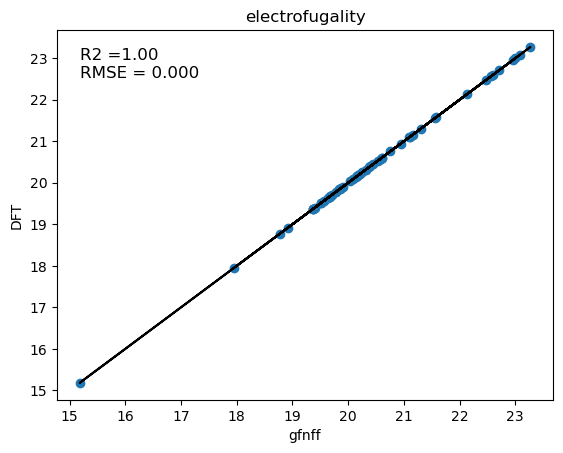

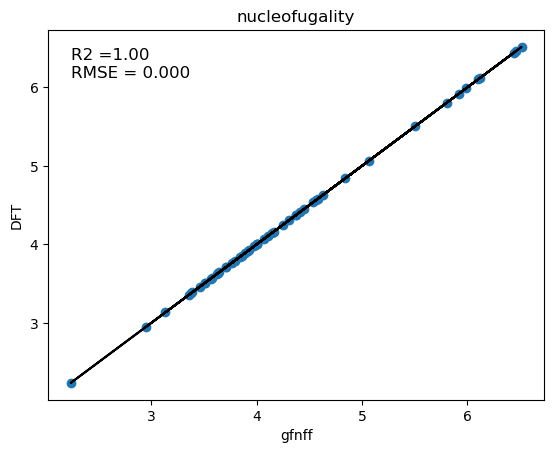

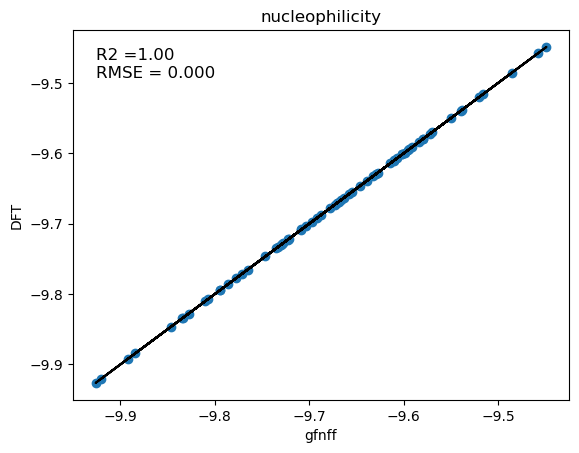

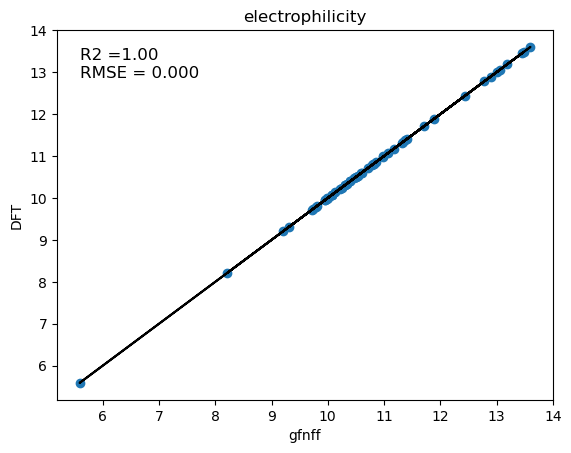

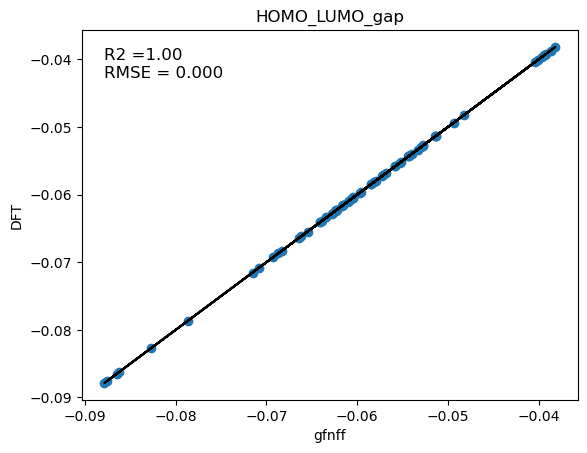

In [14]:
plotter = Plotter()

for i in range(1, len(cols)):
    df2_filtered, df2_filtered, upper, lower = filter(df2,df4,i)
    plotter.plot_correlation(df2_filtered.iloc[:, i], df2_filtered.iloc[:,i], "gfnff")
    plotter.increment()
    # plt.savefig("./figs/gfnff_filter_on_col_" + cols[i] + ".png")

#### gfn2 vs DFT

Plot unfiltered

In [15]:
# plotter = Plotter()

# for i in range(1, len(cols)):
#     plotter.plot_correlation(df3.iloc[:, i], df4.iloc[:,i], "gfn2")
#     plotter.increment()
#     plt.savefig("./figs/gfn2_unfiltered_" + cols[i] + ".png")


Plots filtered

bite_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (65, 14) (65, 14)
--------------------------------------------------
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH0.xyz on pos 20
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH2.xyz on pos 21
Filtered out (upper bound): [Ir+3]_1429939-35-4_OH3.xyz on pos 22
Filtered out (upper bound): [Ir+3]_192463-40-4_OH1.xyz on pos 31
1.204x + -15.229

cone_angle :

Old shape:  (69, 14) (69, 14)
new shape:  (69, 14) (69, 14)
--------------------------------------------------
0.138x + 292.033

buried_volume :

Old shape:  (69, 14) (69, 14)
new shape:  (68, 14) (68, 14)
--------------------------------------------------
Filtered out: (lower bound): [Ir+3]_147253-67-6_OH0.xyz on pos 25
1.071x + -0.031

dispersion :

Old shape:  (69, 14) (69, 14)
new shape:  (69, 14) (69, 14)
--------------------------------------------------
0.810x + 4.090

sasa :

Old shape:  (69, 14) (69, 14)
new shape:  (69, 14) (69, 14)
-------------------------------

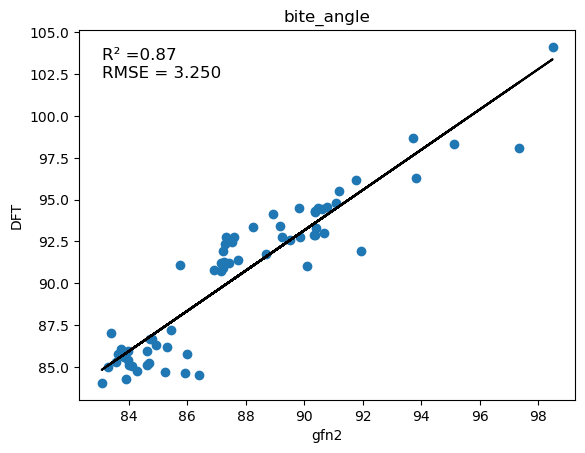

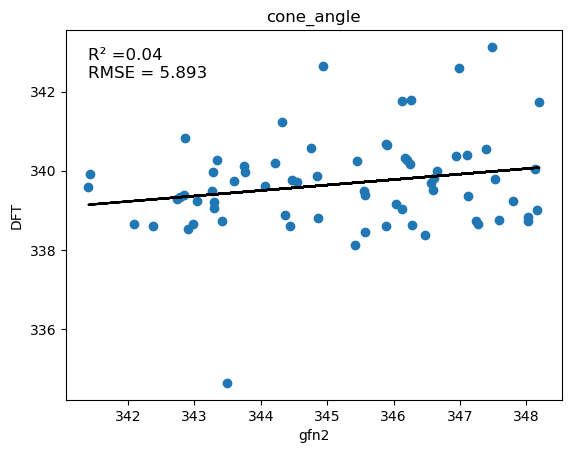

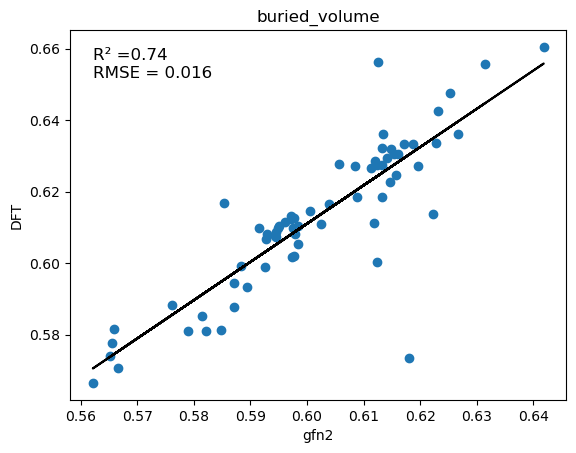

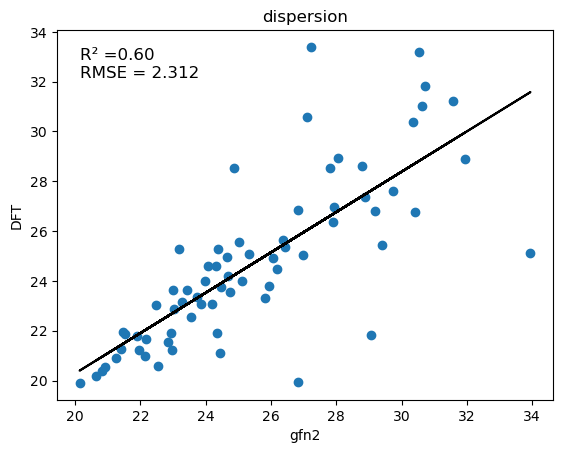

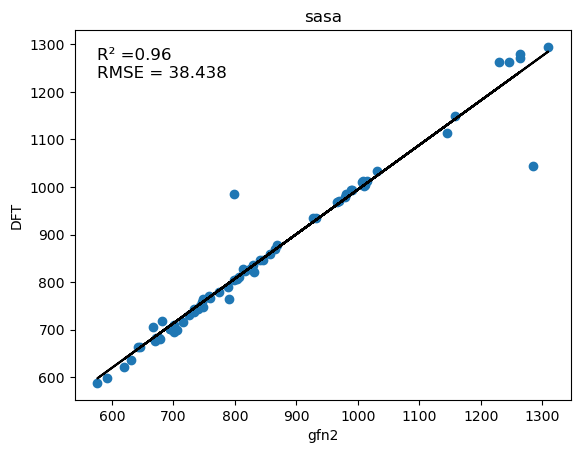

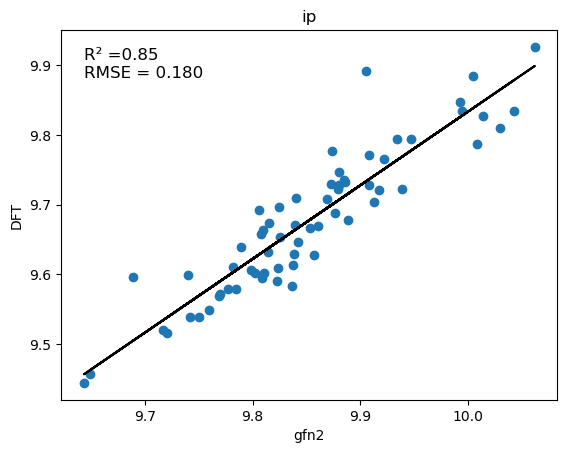

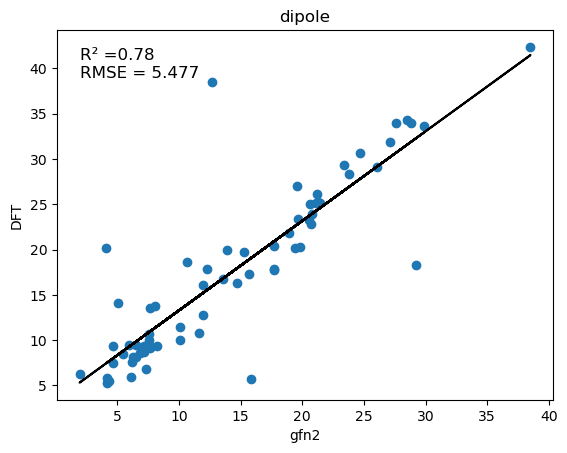

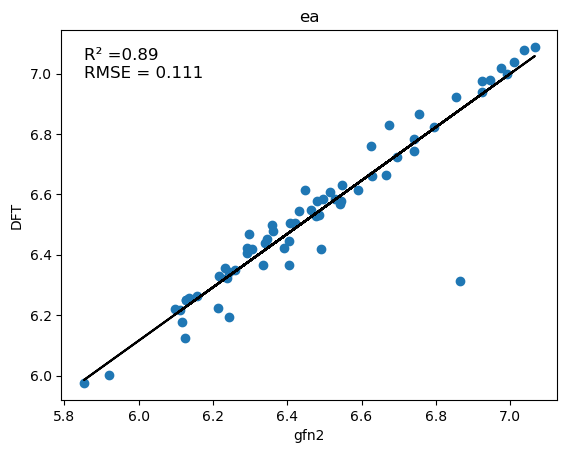

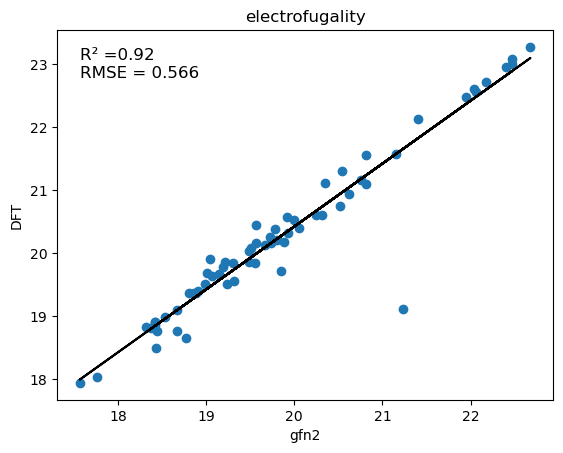

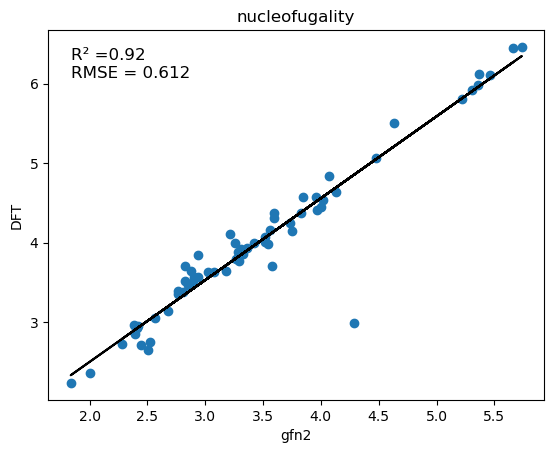

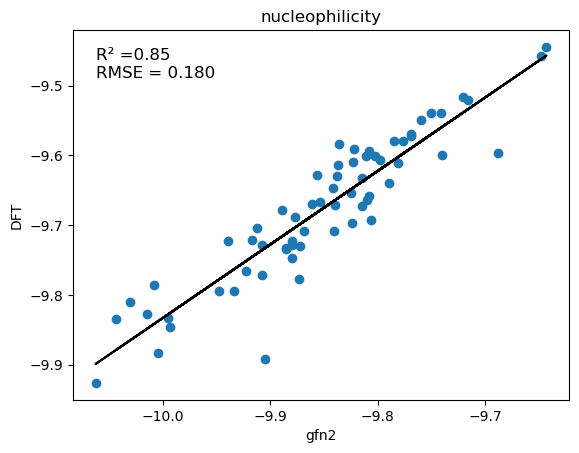

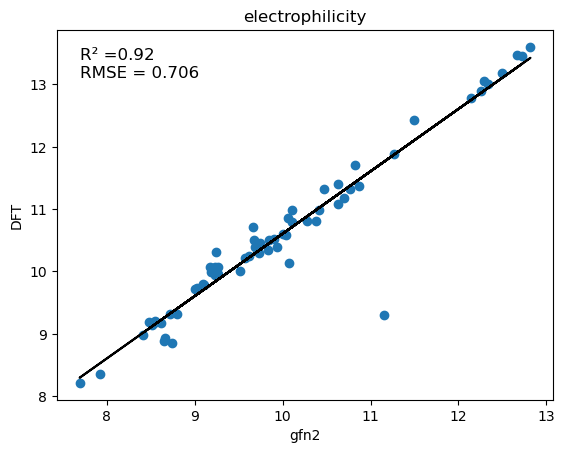

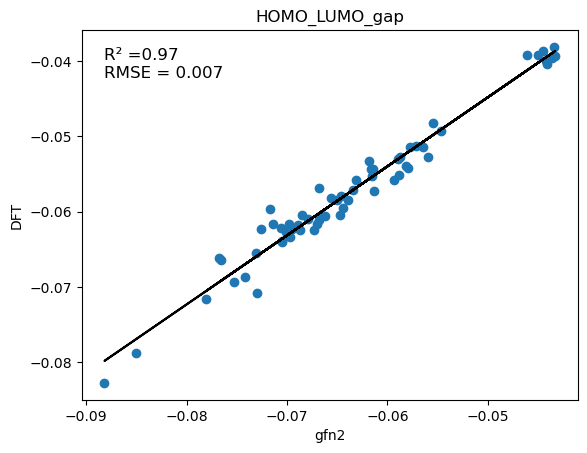

In [52]:
plotter = Plotter()

for i in range(1, len(cols)):
    df3_filtered, df4_filtered, upper, lower = filter(df3,df4,i)
    plotter.plot_correlation(df3_filtered.iloc[:, i], df4_filtered.iloc[:,i], "gfn2")
    plotter.increment()
    # plt.savefig("./figs/gfn2_filter_on_col_" + cols[i] + ".png")



## Correlation matrices  

### Heatmap regular data

<AxesSubplot:>

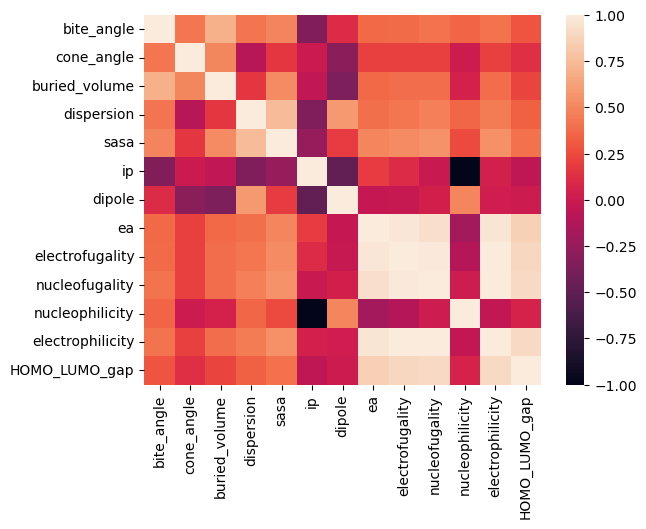

In [17]:
sns.heatmap(df4.corr())

### Correlating between methods

Method for correlation

* calculate correlation of unfiltered data through corrwith -> Output is series
* get two dataframes
* loop
    * filter dataframes on column
    * calculate r2 value
    * append r2 value to list 
* end loop
* loop
* do this for 
    * df1 on df4
    * df2 on df4
    * df3 on df4
* end loop
* gather all r2 value lists in one big list
* create DataFrame from 3 pd.Series and 1 list of 3 lists. 

In [18]:
df1_corr = np.square(df1.corrwith(df4))
df2_corr = np.square(df2.corrwith(df4))
df3_corr = np.square(df3.corrwith(df4))

In [19]:
def calc_r2(x : pd.Series, y : pd.Series ):
    """
    Calculates the r2 of two series
    """
    z = np.polyfit(x,y,1)
    p = np.poly1d(z)   
    coefficient_of_determination = r2_score(y, p(x))
    return coefficient_of_determination

def r2_list(df1 : pd.DataFrame, df2 : pd.DataFrame):
    """
    Filters two DataFrames on all columns and calculates a list of r2 values from the two 
    """
    r2_lst = []
    for i in range(1, len(cols)):
        df1_filtered, df2_filtered, upper, lower = filter(df1,df4,[i])
        r2 = calc_r2(df1_filtered[cols[i]], df2_filtered[cols[i]])
        r2_lst.append(r2)
    return r2_lst


r2_MACE, r2_gfnff, r2_gfn2 = [],[],[]
big_list = []
df_ensemble = [df1,df2,df3]

for i, r2 in enumerate([r2_MACE, r2_gfnff, r2_gfn2]):
    r2 = r2_list(df_ensemble[i],df4) 
    big_list.append(r2)
    

s_r2_mace = pd.Series(big_list[0], index=cols[1:])
s_r2_gfnff = pd.Series(big_list[1], index=cols[1:])
s_r2_gfn2 = pd.Series(big_list[2], index=cols[1:])



Index(['bite_angle'], dtype='object') :

Old shape:  (69, 14) (69, 14)
new shape:  (59, 14) (59, 14)
--------------------------------------------------
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH2.xyz on pos 2
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH3.xyz on pos 3
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH4.xyz on pos 4
Filtered out: (lower bound): [Ir+3]_1202033-19-9_OH5.xyz on pos 5
Filtered out: (lower bound): [Ir+3]_136705-64-1_OH0.xyz on pos 12
Filtered out: (lower bound): [Ir+3]_136705-64-1_OH1.xyz on pos 13
Filtered out: (lower bound): [Ir+3]_136705-65-2_OH0.xyz on pos 14
Filtered out: (lower bound): [Ir+3]_136705-65-2_OH1.xyz on pos 15
Filtered out: (lower bound): [Ir+3]_147253-67-6_OH0.xyz on pos 25
Filtered out: (lower bound): [Ir+3]_147253-67-6_OH1.xyz on pos 26
Index(['cone_angle'], dtype='object') :

Old shape:  (69, 14) (69, 14)
new shape:  (69, 14) (69, 14)
--------------------------------------------------
Index(['buried_volume'], dtype='obje

#### Heatmap

In [20]:
# for adarsh
# corrs = pd.concat([s_r2_mace, s_r2_gfnff, s_r2_gfn2], axis=1)
# corrs.columns = ["MACE", "gnf_FF", "gfn2"]
# sns.heatmap(corrs, annot=True)
# plt.title("R\u00B2 per property compared to DFT optimized structure")

<AxesSubplot:>

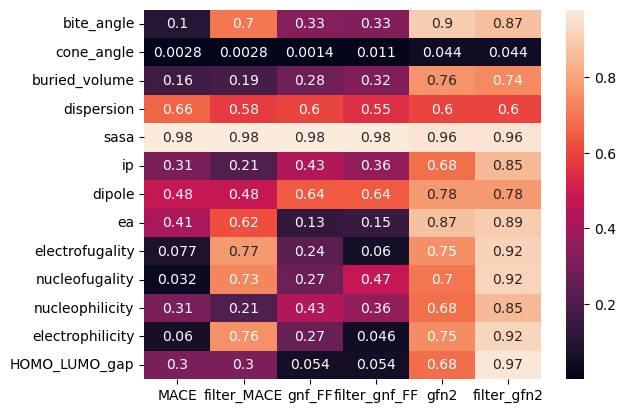

In [21]:
corrs = pd.concat([df1_corr, s_r2_mace, df2_corr, s_r2_gfnff, df3_corr,  s_r2_gfn2], axis=1)
corrs.columns = ["MACE", "filter_MACE", "gnf_FF", "filter_gnf_FF", "gfn2", "filter_gfn2"]
sns.heatmap(corrs, annot=True)


### DFT vs xTB descriptors

#### HOMO LUMO

In [30]:
df_homo_lumo_dft = pd.read_csv("./log_files_dft/HOMO_LUMO_gap_dft.csv")
s_homo_lumo_gap_dft = df_homo_lumo_dft.iloc[:,-1]
s_homo_lumo_gap_xtb = df4[cols[-1]]

s_xtb_filter, s_dft_filter, upper, lower = filter_series(s_homo_lumo_gap_dft, s_homo_lumo_gap_xtb)



Old shape:  69 69
new shape:  63 63
Filtered out (upper bound): -0.1009 on pos 2
Filtered out (upper bound): -0.10787 on pos 3
Filtered out (upper bound): -0.08653 on pos 4
Filtered out (upper bound): -0.08674 on pos 5
Filtered out: (lower bound): -0.08785117111272886 on pos 10
Filtered out: (lower bound): -0.08757701746462304 on pos 51


1.445x + -0.104

Old shape:  69 69
new shape:  65 65
Filtered out: (lower bound): -0.08785117111272886 on pos 10
Filtered out: (lower bound): -0.0864770457093666 on pos 11
Filtered out: (lower bound): -0.08757701746462304 on pos 51
Filtered out: (lower bound): -0.08623974030835219 on pos 52
0.584x + 0.051



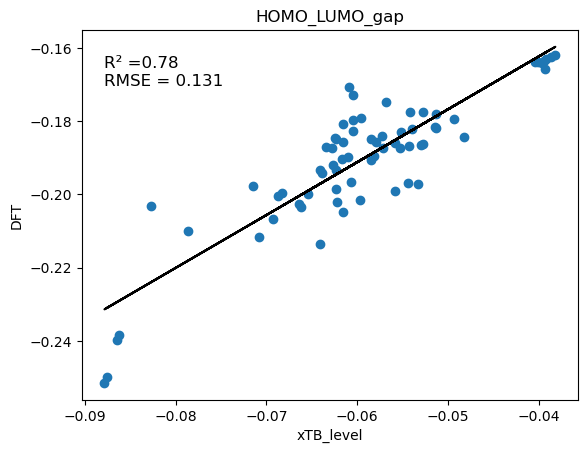

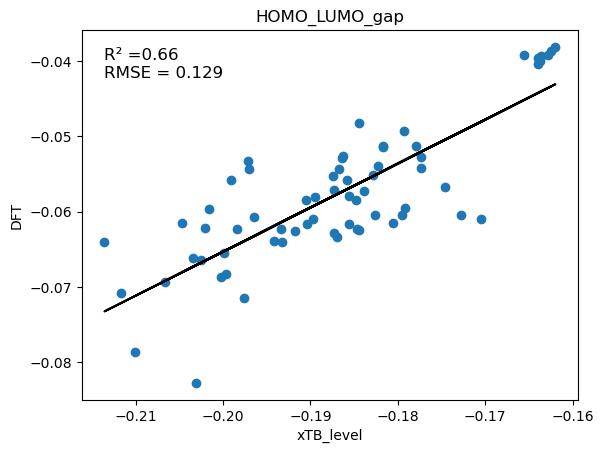

In [48]:
df_homo_lumo_dft = pd.read_csv("./log_files_dft/HOMO_LUMO_gap_dft_new.csv")
s_homo_lumo_gap_dft = df_homo_lumo_dft.iloc[:,-1]
s_homo_lumo_gap_xtb = df4[cols[-1]]

plotter = Plotter(13)
plotter.plot_correlation(s_homo_lumo_gap_xtb, s_homo_lumo_gap_dft, "xTB_level")

s_xtb_filter, s_dft_filter, upper, lower = filter_series(s_homo_lumo_gap_dft, s_homo_lumo_gap_xtb)
plotter = Plotter(13)
plotter.plot_correlation(s_xtb_filter, s_dft_filter, "xTB_level")


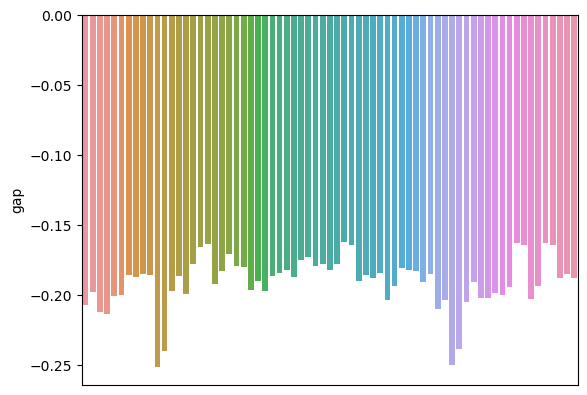

In [45]:
g1 = sns.barplot(data= df_homo_lumo_dft, x=np.arange(len(s_homo_lumo_gap_dft)), y="gap")
g1.set(xticklabels=[])
g1.tick_params(bottom=False)


In [46]:
# top 5 lowest values
df_homo_lumo_dft.sort_values(by=['gap']).tail(5)

,file,homo,lumo,gap
61,[Ir+3]_76189-56-5_OH1,-0.22465,-0.06096,-0.16369
17,[Ir+3]_137219-86-4_OH1,-0.22235,-0.05877,-0.16358
60,[Ir+3]_76189-56-5_OH0,-0.22529,-0.06243,-0.16286
64,[Ir+3]_99646-28-3_OH0,-0.22344,-0.06101,-0.16243
36,[Ir+3]_210169-57-6_OH0,-0.22248,-0.06051,-0.16197


### Dipole


0.292x + 4.601



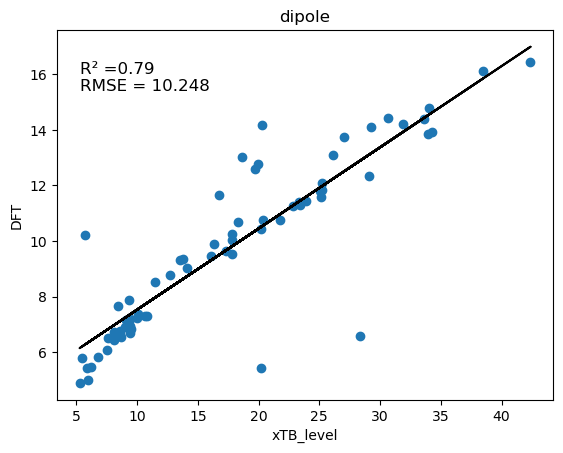

In [11]:
df_dipole_dft = pd.read_excel('./log_files_dft/dipoles_calc.xlsx')
s_dipole_dft = df_dipole_dft["dipole"]

plotter = Plotter(7)

plotter.plot_correlation(df4[cols[7]],s_dipole_dft,"xTB_level")

## All values per structure

#### Linechart

C:\Users\aydin\AppData\Local\Temp\ipykernel_736\2382896986.py:20: UserWarning: Glyph 11789 (\N{RIGHT RAISED OMISSION BRACKET}) missing from current font.
  plt.savefig("all_values_" + cols[i])


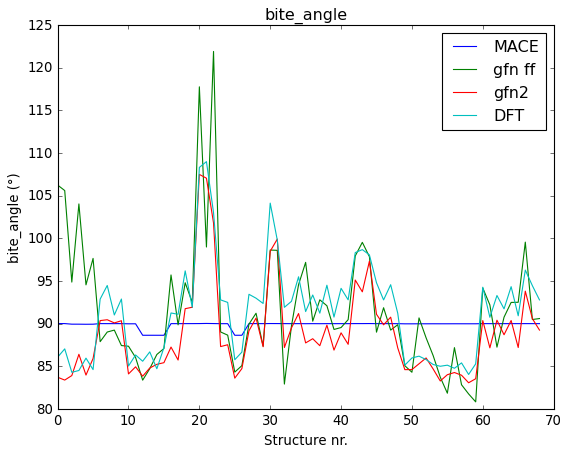

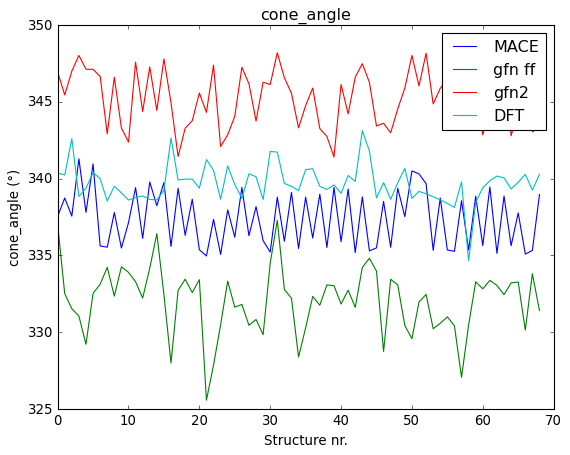

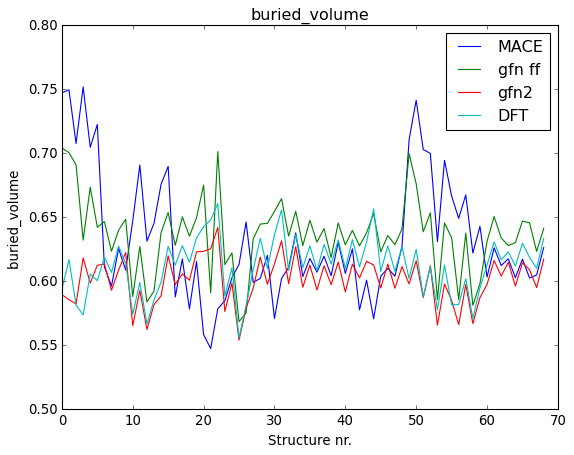

c:\Users\aydin\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 11789 (\N{RIGHT RAISED OMISSION BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


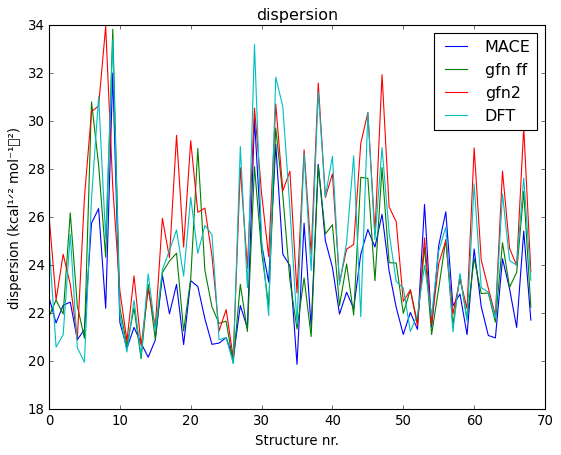

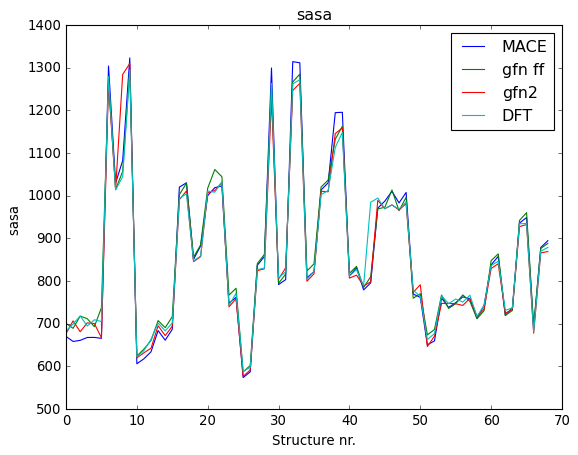

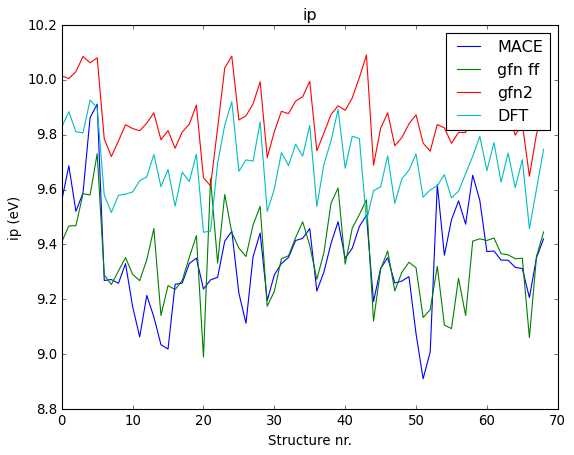

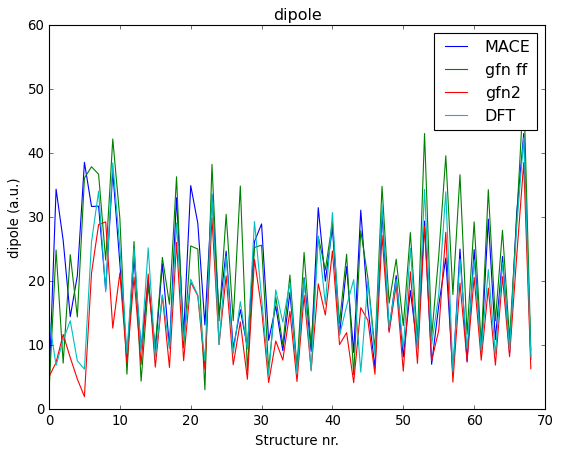

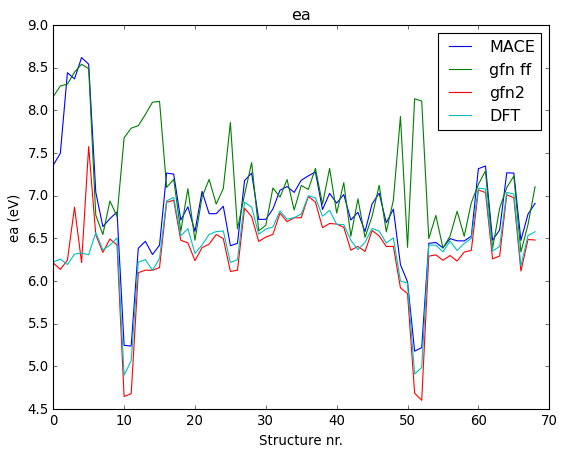

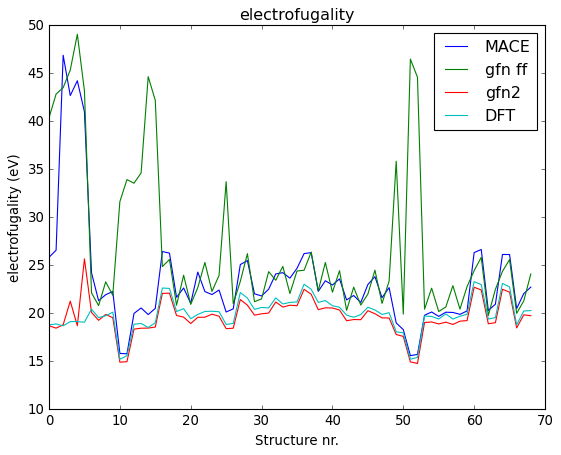

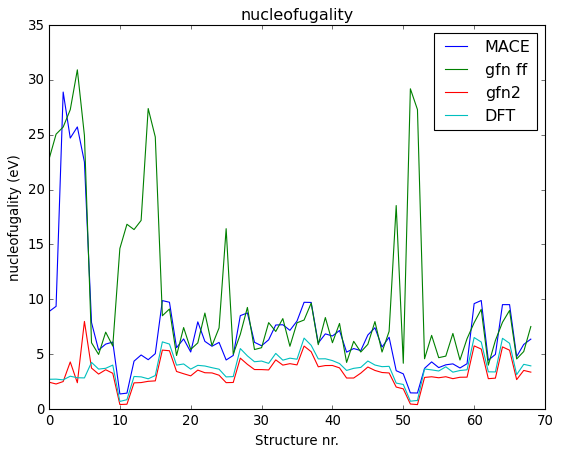

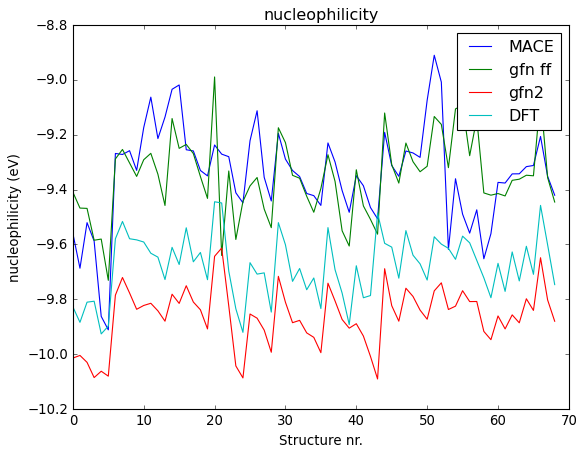

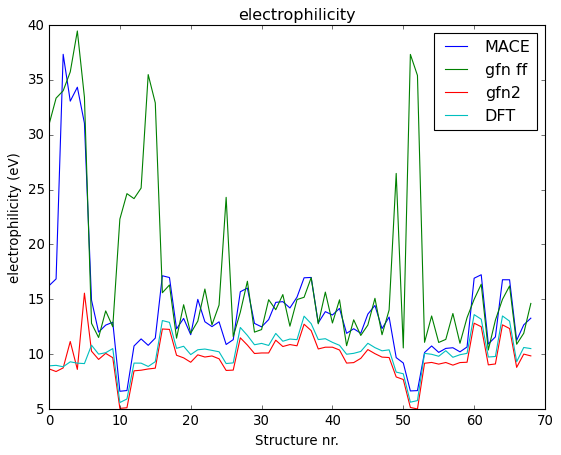

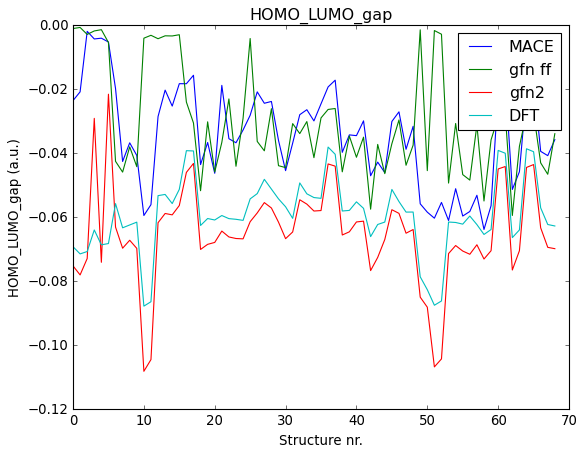

In [ ]:
plt.style.use("classic")
def plot_all_vals(col_nr):
    
    x=range(len(df1.iloc[:,0]))
    
    # plt.figure()
    fig,ax = plt.subplots()
    fig.set_facecolor("white")
    plt.plot(x,df1.iloc[:,col_nr], label="MACE")
    plt.plot(x,df2.iloc[:,col_nr], label="gfn ff")
    plt.plot(x,df3.iloc[:,col_nr], label="gfn2")
    plt.plot(x,df4.iloc[:,col_nr], label="DFT")
    plt.xlabel("Structure nr.")
    plt.ylabel(cols[col_nr] + " " + units[col_nr])
    plt.title(cols[col_nr])
    plt.legend()

for i in range(1,len(cols)):
    plot_all_vals(i)
    plt.savefig("all_values_" + cols[i])

#### Barchart

In [ ]:
#bar chart

# x=range(len(df1.iloc[:,0]))
# width = 0.25
# # sns.barplot()
# plt.bar(x,df1.iloc[:,-1])
# plt.bar(x+width,df2.iloc[:,-1], width)
# plt.bar(x+2*width,df3.iloc[:,-1], width*2)
# plt.bar(x+3*width,df4.iloc[:,-1], width*3)

In [ ]:
# Difference in colinearity between gfn2 and DFT
np.abs(df3.corr() - df4.corr())

df4.compare(df3)

Unnamed: 0                              bite_angle  \
                           self                        other       self   
0                           NaN                          NaN  86.075599   
1   [Ir+3]_1202033-19-9_OH1.xyz  [Ir+3]_1202033-19-9_OH2.xyz  87.044538   
2   [Ir+3]_1202033-19-9_OH2.xyz  [Ir+3]_1202033-19-9_OH3.xyz  84.301617   
3   [Ir+3]_1202033-19-9_OH3.xyz  [Ir+3]_1202033-19-9_OH4.xyz  84.511006   
4   [Ir+3]_1202033-19-9_OH4.xyz  [Ir+3]_1202033-19-9_OH5.xyz  85.959606   
..                          ...                          ...        ...   
64                          NaN                          NaN  94.336449   
65                          NaN                          NaN  90.923161   
66                          NaN                          NaN  96.281552   
67                          NaN                          NaN  94.451598   
68                          NaN                          NaN  92.785900   

               cone_angle             buried_volume           dispersion  \
        other        self       other          self     other       self   
0   83.721935  340.364045  346.943045      0.593354  0.589394  24.916779   
1   83.389396  340.236363  345.446414      0.616824  0.585352  20.580290   
2   83.917372  342.590848  346.991946      0.581153  0.582126  21.091922   
3   86.411148  338.835221  348.016998      0.573350  0.618029  25.283895   
4   83.975085  339.374897  347.117944      0.605415  0.598368  20.552306   
..        ...         ...         ...           ...       ...        ...   
64  90.371014  339.325737  342.787882      0.611617  0.596045  26.963170   
65  87.204783  339.763539  344.472129      0.629490  0.614220  24.185625   
66  93.808029  340.273890  346.198485      0.618408  0.608793  23.992427   
67  90.589778  339.249482  343.045627      0.609893  0.594833  27.624425   
68  89.248714  340.276570  343.343088      0.633211  0.617132  23.367059   

               ... electrofugality            nucleofugality            \
        other  ...            self      other           self     other   
0   26.065878  ...       18.759651  18.671018       2.709431  2.444328   
1   22.548209  ...       18.862969  18.420340       2.721930  2.280281   
2   24.447433  ...       18.659491  18.775555       2.656204  2.501221   
3   23.193832  ...       19.108399  21.236981       2.987055  4.286669   
4   20.922728  ...       19.105173  18.672887       2.850742  2.394913   
..        ...  ...             ...        ...            ...       ...   
64  27.913723  ...       23.086215  22.468603       6.441773  5.659799   
65  24.695326  ...       22.715122  22.174293       5.986600  5.358754   
66  23.978765  ...       18.770109  18.444292       3.135757  2.679338   
67  29.733277  ...       20.206695  19.805458       4.072193  3.516395   
68  23.718690  ...       20.254085  19.720549       3.930822  3.360330   

   nucleophilicity            electrophilicity            HOMO_LUMO_gap  \
              self      other             self      other          self   
0        -9.827693 -10.014383         8.931957   8.656635     -0.069281   
1        -9.884019 -10.004677         8.978950   8.415663     -0.071529   
2        -9.810503 -10.029927         8.848988   8.745628     -0.070793   
3        -9.807042 -10.085431         9.301357  11.151550     -0.064048   
4        -9.926210 -10.062289         9.178962   8.610598     -0.068699   
..             ...        ...              ...        ...           ...   
64       -9.606757  -9.798068        13.479458  12.670535     -0.038681   
65       -9.709032  -9.840651        13.006090  12.333642     -0.039597   
66       -9.457678  -9.648471         9.312431   8.795822     -0.057145   
67       -9.601403  -9.802352        10.605292  10.003107     -0.062343   
68       -9.746490  -9.880084        10.507594   9.840464     -0.062805   

              
       other  
0  -0.075276  
1  -0.078097  
2  -0.072979  
3  -0.029175  
4  -0.074152  
..       ...

## Seaborn regression plots

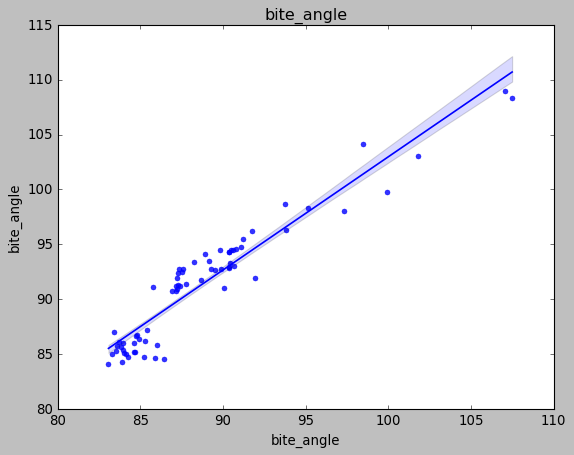

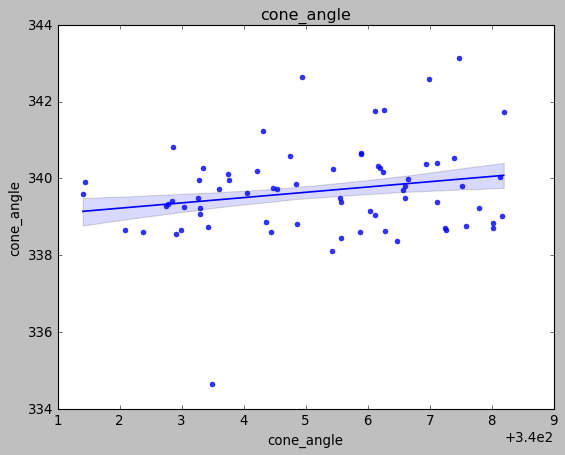

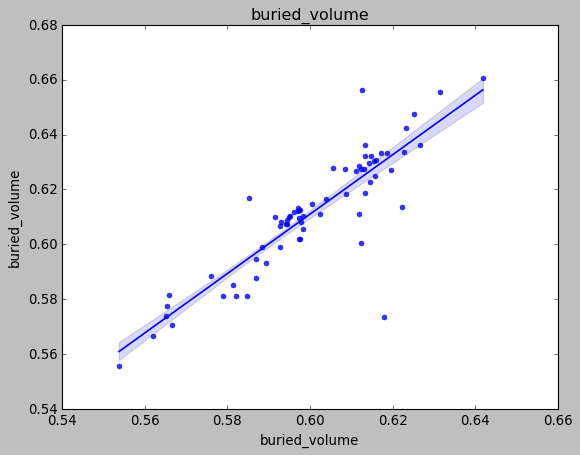

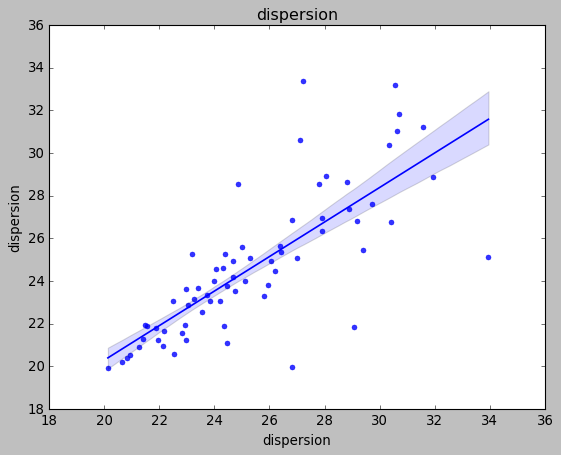

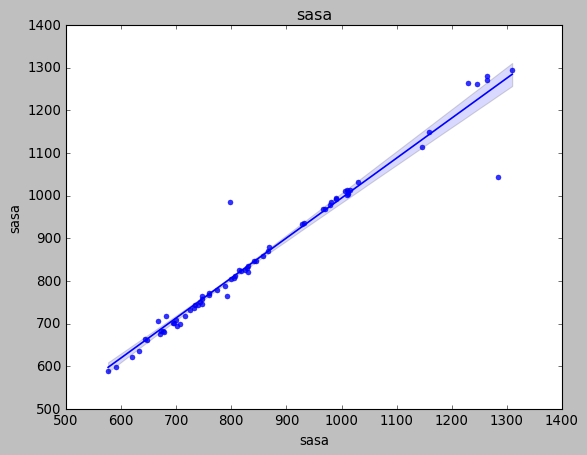

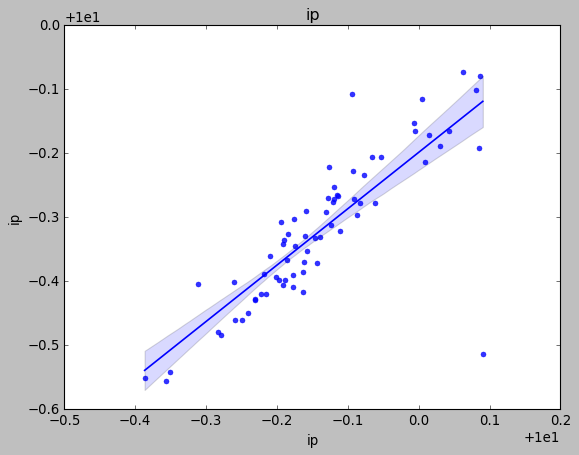

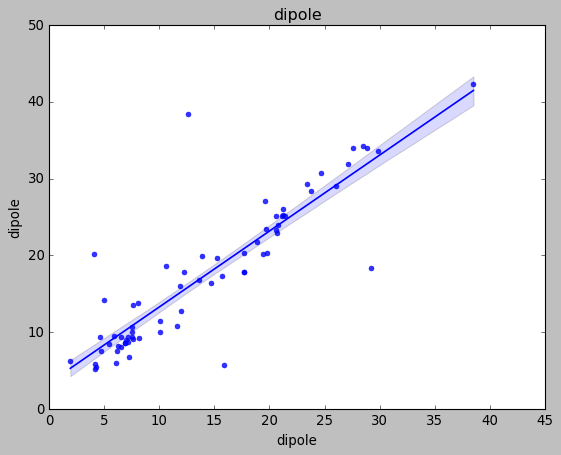

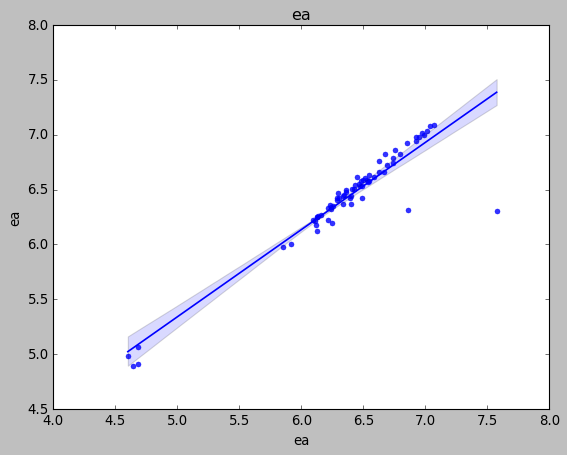

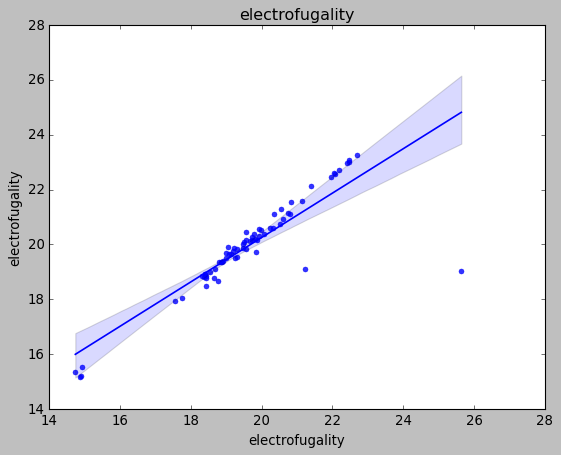

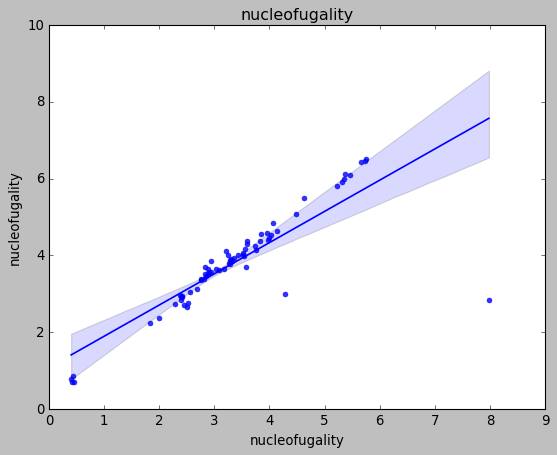

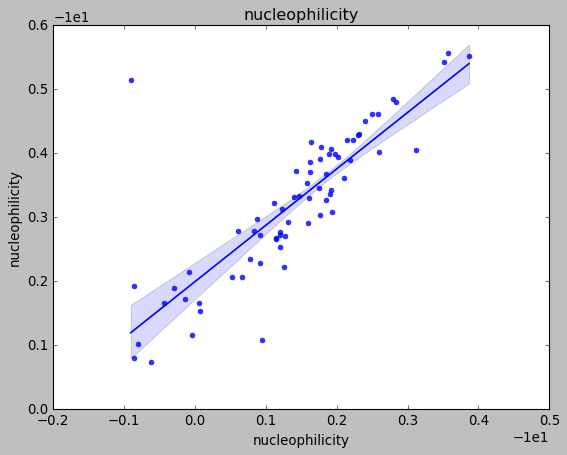

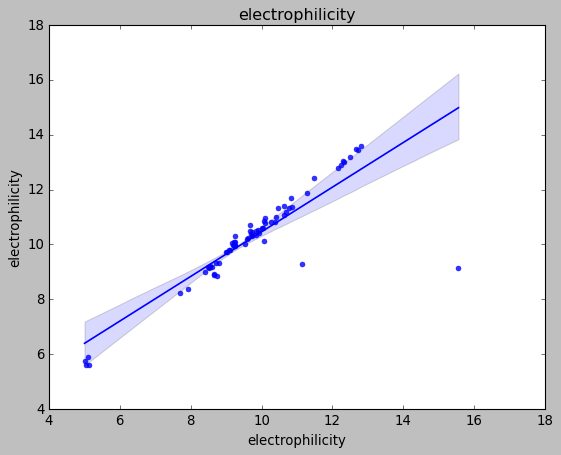

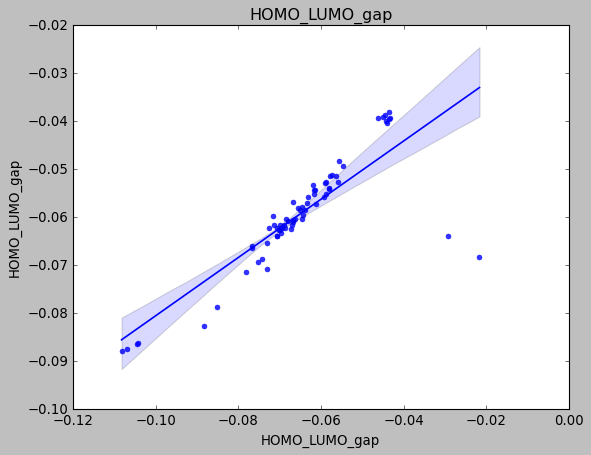

In [ ]:
cols_no_string = cols.delete(0)

for i, col in enumerate(cols_no_string):
    plt.figure()
    plt.title(col)
    sns.regplot(x=df3[col],y=df4[col], ci=75)

## Energy readings

In [ ]:
df5=pd.read_excel("./adapted_sheets/all_energies.xlsx")

df5


,Strucs,E_MACE,E_gfnff,E_gfn2,E_DFT,Unnamed: 5,Unnamed: 6,diff MACE DFT,diff gfnf DFT,diff gfn2 DFT
0,[Ir+3]_1202033-19-9_OH0,-2152.565417,-2153.010725,-2153.378039,-2153.409358,NaN,NaN,-0.843941,-0.398633,-0.031319
1,[Ir+3]_1202033-19-9_OH1,-2152.567917,-2152.977072,-2153.367270,-2153.395034,NaN,NaN,-0.827117,-0.417961,-0.027763
2,[Ir+3]_1202033-19-9_OH2,-2151.672273,-2152.943653,-2153.360039,-2153.386815,NaN,NaN,-1.714541,-0.443162,-0.026776
3,[Ir+3]_1202033-19-9_OH3,-2151.762589,-2152.946997,-2153.364106,-2153.391467,NaN,NaN,-1.628878,-0.444470,-0.027361
4,[Ir+3]_1202033-19-9_OH4,-2151.695011,-2152.889458,-2153.337835,-2153.375497,NaN,NaN,-1.680486,-0.486039,-0.037662
...,...,...,...,...,...,...,...,...,...,...
64,[Ir+3]_99646-28-3_OH0,-2770.716802,-2770.718713,-2770.770883,-2770.803002,NaN,NaN,-0.086200,-0.084288,-0.032118
65,[Ir+3]_99646-28-3_OH1,-2770.700339,-2770.707414,-2770.760734,-2770.795872,NaN,NaN,-0.095533,-0.088458,-0.035138
66,[Ir+3]_MFCD09753011_OH0,-2083.986561,-2084.001803,-2084.049464,-2084.077439,NaN,NaN,-0.090878,-0.075636,-0.027975
67,[Ir+3]_MFCD19443622_OH0,-2764.283807,-2764.293593,-2764.351265,-2764.382888,NaN,NaN,-0.099081,-0.089295,-0.031623
